# Préparation des données

## Import et data augmentations

Montage google drive et décompression des données de bdappv.zip

In [2]:
import sys
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
!unzip /content/drive/MyDrive/bdappv/bdappv.zip > /dev/null

Mounted at /content/drive/


Importation des fichiers dataloader, metrics et resnet18

In [3]:
!cp /content/drive/MyDrive/statapps-main/src/dataloader.py /content
!cp /content/drive/MyDrive/statapps-main/src/metrics.py /content
!cp /content/drive/MyDrive/statapps-main/src/resnet18.py /content

In [4]:
import dataloader as dtld
from metrics import *
import resnet18
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [5]:
label_attribution = dtld.LabelAttribution(path_image_google='/content/bdappv/google/img', 
                                   path_mask_google='/content/bdappv/google/mask',
                                   path_metadata='/content/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test='/content/drive/MyDrive',
                                   path_image_ign='/content/bdappv/ign/img',
                                   path_mask_ign='/content/bdappv/ign/mask',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [6]:
label_attribution.run()

In [1]:
path_train='/content/drive/MyDrive/train_data.csv'
path_test='/content/drive/MyDrive/test_data.csv'

transformed_train_dataset  = dtld.CustomImageDataset(path_train,'/content/bdappv/google/img', transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.5, 0.5)),
                                               transforms.RandomCrop(160),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.RandomRotation(degrees = (0,180)),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.2969593107700348, 0.29610514640808105, 0.29613879323005676],
                                                                    std= [0.19015252590179443, 0.18941254913806915, 0.18982695043087006])

                                           ]))

#On resize uniquement sur le test
transformed_test_dataset = dtld.CustomImageDataset(path_test,'/content/bdappv/google/img',
                                            transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3499923348426819, 0.3576664924621582, 0.3081061840057373],
                                                                    std= [0.16761955618858337, 0.14885342121124268, 0.1473139077425003])
                                           ]))

NameError: name 'dtld' is not defined

In [8]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [9]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=5762, shuffle=True)

 # Implémentation ResNet18

In [10]:
from keras.optimizers import SGD
import keras
import tensorflow as tf

model = resnet18.buildModel()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                          

In [ ]:
X_train, Y_train=next(iter(train_dataloader))
X_test, Y_test=next(iter(test_dataloader))

In [ ]:
X_train_permute=X_train.permute(0, 2, 3,1)
X_test_permute=X_test.permute(0, 2, 3,1)

# Lancement du modèle

Les cinq premières métriques représentent les performances de notre algorithme sur l'échantillon d'entrainement, les cinq dernières valeurs (celles précédées du préfixe val_) sont elles calculées sur l'échantillon de test. 

In [ ]:
model.fit(x = X_train_permute.numpy(), y = Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=32,
	epochs=5)

Epoch 1/5
1/1 [==============================] - 270s 270s/step - loss: 1.1313 - Accuracy: 0.4375 - recall_m: 0.4706 - precision_m: 0.4706 - f1_m: 0.4706 - val_loss: 1.0626 - val_Accuracy: 0.5000 - val_recall_m: 0.8235 - val_precision_m: 0.5185 - val_f1_m: 0.6364
Epoch 2/5
1/1 [==============================] - 192s 192s/step - loss: 1.1129 - Accuracy: 0.4688 - recall_m: 0.5294 - precision_m: 0.5000 - f1_m: 0.5143 - val_loss: 1.0626 - val_Accuracy: 0.5000 - val_recall_m: 0.8235 - val_precision_m: 0.5185 - val_f1_m: 0.6364
Epoch 3/5
1/1 [==============================] - 187s 187s/step - loss: 1.0952 - Accuracy: 0.4688 - recall_m: 0.5294 - precision_m: 0.5000 - f1_m: 0.5143 - val_loss: 1.0628 - val_Accuracy: 0.4688 - val_recall_m: 0.7647 - val_precision_m: 0.5000 - val_f1_m: 0.6047
Epoch 4/5
1/1 [==============================] - 198s 198s/step - loss: 1.0784 - Accuracy: 0.5312 - recall_m: 0.5882 - precision_m: 0.5556 - f1_m: 0.5714 - val_loss: 1.0634 - val_Accuracy: 0.4375 - val_recall

In [ ]:
loss, accuracy, recall_m, precision_m, f1_m = model.evaluate(X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(np.round(loss,3)))
print("Accuracy sur l'échantillon test: {}".format(np.round(accuracy,3)))
print("Recall sur l'échantillon test: {}".format(np.round(recall_m,3)))
print("Precision sur l'échantillon test: {}".format(np.round(precision_m,3)))
print("F1-score sur l'échantillon test: {}".format(np.round(f1_m,3)))

Loss sur l'échantillon test: 1.064
Accuracy sur l'échantillon test: 0.438
Recall sur l'échantillon test: 0.706
Precision sur l'échantillon test: 0.48
F1-score sur l'échantillon test: 0.571


In [ ]:
prob_predict = model.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

1/1 [==============================] - 38s 38s/step


In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
res=dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Nombre d'images prédites avec panneaux: 25
Nombre d'images prédites sans panneau: 7


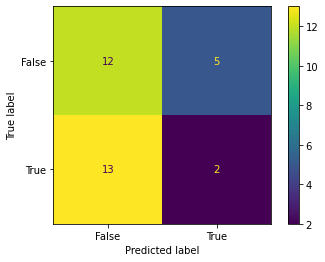

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

r = confusion_matrix(Y_test, y_pred)
r = np.flip(r)

cm_display = ConfusionMatrixDisplay(confusion_matrix = r, display_labels = [False, True])
cm_display.plot()
plt.show()